# Projet 5 - <font color='green'>Notebook 2</font> - Segmentez des clients d'un site e-commerce

L'objectif de ce projet est de réaliser une segmentation de clients à partir des [données du site de commerce électronique Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

Les données de base sont constituées de 9 fichiers et concernent les commandes effectuées au cours d'une période de 2 ans. Les fichiers ne fournissent pas d'information sur les clients autres que celles nécessaires aux commandes par e-commerce (localisation, commandes effectuées, dates, articles commandés, prix, paiements et éventuels commentaires clients). Pour cette raison, la segmentation est centrée sur l'approche RFM (Récence, Fréquence et Montant des commandes), enrichie le cas échéant par des caractéristiques complémentaires.

Le projet consiste à :

- (a) constituer un jeu de données clients nettoyé,
- (b) l'analyser pour en acquérir la meilleure compréhension,
- (c) identifier les caractéristiques utiles à la segmentation,
- (d) préparer les données pour le machine learning : transformation et réduction de la dimensionnalité afin de permettre la visualisation,
- (e) effectuer des apprentissages non supervisés avec différents algorithmes pour déterminer le clustering le plus pertinent,
- (f) effectuer l'analyse métier du clustering pour en valider l'usage par le marketing de l'entreprise
- (g) estimer la pérennité du modèle de clustering dans le temps afin de donner de la visibilité sur son temps d'utilisation comparé au délai de réalisation des actions marketing.

Le Notebook 2 couvre l'étape (d) ci-dessus.

## Livrables
Ce projet est mené en langage Python, utilisant les librairies Numpy, Pandas, Matplotlib et Seaborn.
Le machine learning utilise principalement les librairies scikit-learn et scipy.
Les versions sont vérifiées en début de script de ce Notebook.
L'IDE utilisé est Pycharm.

Le rapport est constitué des fichiers suivants :
- Notebook 1 - Analyse exploratoire <font color='green'>P5_notebook1_analyse_exploratoire.ipynb</font>
- Notebook 2 - Feature engineering <font color='green'>P5_notebook2_feature_engineering.ipynb</font>
- Notebook 3 - Modèle de clustering <font color='green'>P5_notebook3_modele_clustering.ipynb</font>
- Notebook 4 - Maintenance des clusters <font color='green'>P5_notebook4_maintenance_clusters.ipynb</font>
- Fichier des fonctions Python utilisées par les notebooks <font color='green'>P5_fonctions.py</font>
- Les fichiers de données se trouvent dans le répertoire <font color='green'>.\P5_data</font>

<a id="sommaire"></a>
## Sommaire
1. [Initialisations](#init)
&nbsp;
2. [Chargement et transformation des features](#read_preproc)
    1. [Chargement du jeu de données](#file_reading)
    2. [Transformation des features catégorielles](#preproc_cat)
    3. [Examen des features numériques](#exam)
    4. [Transformation des features](#preproc_num)
    5. [Résultat du jeu transformé](#dataset)
3. [Analyse en composantes principales](#acp)
    6. [ACP sur l'ensemble des features numériques](#acp_gen)
    7. [ACP sur les features RFM](#acp_rfm)
    8. [Combinaison RFM avec les variables catégorielles](#acp_rfm_cat)
4. [Analyse en composantes principales mixte variables numériques et catégorielles](#acp_mix)
    1. [ACP mixte en mettant en évidence les Etats](#acp_mix_states)
    2. [ACP mixte en mettant en évidence les caractéristiques de paiement](#acp_mix_pay)
5. [Visualisation avec t-SNE](#tsne)
&nbsp;
6. [Conclusion](#conclusion)

<a id="init"></a>
## 1 - Initialisations

In [1]:
# Import des librairies et fonctions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

import nltk
import copy
import sys

# Fonctions support du projet
import P5_fonctions as fct

# Mesure du temps de calcul:
import timeit
#start_time = timeit.default_timer()
# ... code dont on veut mesurer la durée ...
#elapsed = timeit.default_timer() - start_time
#print(f"Temps de calcul {fct.elapsed_format(elapsed)}")

# Pour afficher les graphiques dans le Notebook
%matplotlib inline
# Pour afficher les graphiques dans une fenêtre matplotlib
#%matplotlib qt

# Gestion des conflits d'installation de ipython et jupyter avec windows:
# - installer pipwin (pip install pipwin), puis
# - installer ipython et jupyter avec pipwin

# Display options
from IPython.display import display, display_html, display_png, display_svg, Image
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# Colorama
from colorama import Fore, Back, Style
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL

# Affiche les versions de Python et packages
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + 'Versions de Python et des principales librairies utilisées :\n' +
      Style.RESET_ALL)
print('- Python : ' + sys.version)
print('- Numpy : ' + np.__version__)
print('- Pandas : ' + pd.__version__)
print('- Matplotlib : ' + mpl.__version__)
print('- Seaborn : ' + sns.__version__)

!jupyter --version

# Suppression des warnings de dépréciation lié à l'utilisation de fig.colorbar
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Versions de Python et des principales librairies utilisées :

- Python : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
- Numpy : 1.22.4
- Pandas : 1.4.2
- Matplotlib : 3.5.2
- Seaborn : 0.11.2
Selected Jupyter core packages...
IPython          : 8.4.0
ipykernel        : 6.13.0
ipywidgets       : 7.7.0
jupyter_client   : 7.3.1
jupyter_core     : 4.10.0
jupyter_server   : 1.13.5
jupyterlab       : 3.2.9
nbclient         : 0.6.3
nbconvert        : 6.5.0
nbformat         : 5.4.0
notebook         : 6.4.11
qtconsole        : 5.3.0
traitlets        : 5.2.1.post0


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="read_preproc"></a>
## 2 - Chargement et transformation des features

<a id="file_reading"></a>
### 2.1 - Chargement du jeu de données

In [2]:
# Répertoire et fichiers de données
data_dir = '.\P5_data'
file = 'data_customers.csv'

# Chargement du jeu de données
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Chargement du jeu de données\n" + Style.RESET_ALL)
data = pd.read_csv(data_dir + "\\" + file , sep=';', encoding='utf-8-sig', index_col='customer_unique_id', low_memory=False)
print(Fore.GREEN + "► Informations :" + Style.RESET_ALL)
display(data.info())
print(Fore.GREEN + "► Entête et fin de jeu de données :" + Style.RESET_ALL)
display(pd.concat([data.head(2), data.tail(2)], axis=0))

Chargement du jeu de données

► Informations :
<class 'pandas.core.frame.DataFrame'>
Index: 93396 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_state        93396 non-null  object 
 1   recency               93396 non-null  float64
 2   frequency             93396 non-null  float64
 3   monetary              93396 non-null  float64
 4   review_score          93396 non-null  float64
 5   payment_sequential    93396 non-null  int64  
 6   payment_installments  93396 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.7+ MB


None

► Entête et fin de jeu de données :


,customer_state,recency,frequency,monetary,review_score,payment_sequential,payment_installments
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,SP,115.924,0.5,141.90,5.0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,SP,118.914,0.5,27.19,4.0,0,0
ffff5962728ec6157033ef9805bacc48,OS,123.743,0.5,133.69,5.0,0,1
ffffd2657e2aad2907e67c3e9daecbeb,OS,488.533,0.5,71.56,5.0,0,1


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="preproc_cat"></a>
### 2.2 - Transformation des features catégorielles
Les features catégorielles sont 'customer_state', 'payment_sequential' et 'payment_installments'.
Nous allons appliquer 3 types de transformation (cf [FAMD: How to generalize PCA to categorical and numerical data](#https://medium.com/towards-data-science/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210)) :
- Transformation en valeurs binaires (0 ou 1) ;
- Division des valeurs de chaque variable par la racine carrée de la probabilité (fréquence) de la valeur 1 ;
- Standardisation de chaque variable (centrage).

La première transformation ne concerne que 'customer_state' que nous allons diviser en autant de variables à valeur binaire qu'elle contient de catégories (nous avions déjà simplifié les catégories dans le notebook 1).

In [3]:
# customer_state
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Transformation OneHot de la feature 'customer_state'\n" + Style.RESET_ALL)

# Transformation en variables binaires
# Customer_state
df = pd.get_dummies(data['customer_state'], prefix='state')
print(Fore.GREEN + "► Variable 'customer_state' encodée selon ses catégories (one-hot) :" + Style.RESET_ALL)
display(df.sum().sort_values(ascending=False))
print(f"Taux de 'Other State - OS' : {100*df.sum()['state_OS']/df.sum().sum():.1f}%\n")
data = pd.concat([data, df], axis=1)
data.drop(labels=['customer_state'], axis=1, inplace=True)

# payment_sequential
df = pd.get_dummies(data['payment_sequential'], prefix='pay_seq')
print(Fore.GREEN + "► Variable 'payment_sequential' encodée selon ses catégories (one-hot) :" + Style.RESET_ALL)
display(df.sum().sort_values(ascending=False))
print(f"Taux de paiement séquentiel : {100*df.sum()['pay_seq_1']/df.sum().sum():.1f}%\n")
data = pd.concat([data, df], axis=1)
data.drop(labels=['payment_sequential'], axis=1, inplace=True)

# payment_installments
df = pd.get_dummies(data['payment_installments'], prefix='pay_inst')
print(Fore.GREEN + "► Variable 'payment_installments' encodée selon ses catégories (one-hot) :" + Style.RESET_ALL)
display(df.sum().sort_values(ascending=False))
print(f"Taux de paiement en plusieurs fois : {100*df.sum()['pay_inst_1']/df.sum().sum():.1f}%\n")
data = pd.concat([data, df], axis=1)
data.drop(labels=['payment_installments'], axis=1, inplace=True)

print(Fore.GREEN + "► Nouvelles dimensions du jeu de données :" + Style.RESET_ALL, f"{data.shape}\n")

# Autres transformations
cat_var = ['state_MG', 'state_OS', 'state_RJ', 'state_SP', 'pay_seq_0', 'pay_seq_1', 'pay_inst_0', 'pay_inst_1']
print(Fore.GREEN + "► Pondération et centrage des variables OHE :" + Style.RESET_ALL)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(Fore.GREEN + "  → Variables avant centrage et pondération :" + Style.RESET_ALL)
display(data[cat_var].describe().iloc[1:3,:])
for var in cat_var:
    data[var] = data[var] / np.sqrt(data[var].sum()/len(data[var]))
    data[var] = data[var] - data[var].mean()
print(Fore.GREEN + "  → Variables après centrage et pondération :" + Style.RESET_ALL)
display(data[cat_var].describe().iloc[1:3,:])
print(Fore.GREEN + "  → Premières lignes :" + Style.RESET_ALL)
display(data[cat_var].head(5))

Transformation OneHot de la feature 'customer_state'

► Variable 'customer_state' encodée selon ses catégories (one-hot) :


state_SP    39184
state_OS    31297
state_RJ    11971
state_MG    10944
dtype: int64

Taux de 'Other State - OS' : 33.5%

► Variable 'payment_sequential' encodée selon ses catégories (one-hot) :


pay_seq_0    90505
pay_seq_1     2891
dtype: int64

Taux de paiement séquentiel : 3.1%

► Variable 'payment_installments' encodée selon ses catégories (one-hot) :


pay_inst_1    48279
pay_inst_0    45117
dtype: int64

Taux de paiement en plusieurs fois : 51.7%

► Nouvelles dimensions du jeu de données : (93396, 12)

► Pondération et centrage des variables OHE :
  → Variables avant centrage et pondération :


,state_MG,state_OS,state_RJ,state_SP,pay_seq_0,pay_seq_1,pay_inst_0,pay_inst_1
mean,0.117,0.335,0.128,0.420,0.969,0.031,0.483,0.517
std,0.322,0.472,0.334,0.493,0.173,0.173,0.500,0.500


  → Variables après centrage et pondération :


,state_MG,state_OS,state_RJ,state_SP,pay_seq_0,pay_seq_1,pay_inst_0,pay_inst_1
mean,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000
std,0.940,0.815,0.934,0.762,0.176,0.984,0.719,0.695


  → Premières lignes :


,state_MG,state_OS,state_RJ,state_SP,pay_seq_0,pay_seq_1,pay_inst_0,pay_inst_1
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.342,-0.579,-0.358,0.896,0.031,-0.176,-0.695,0.672
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.342,-0.579,-0.358,0.896,0.031,-0.176,0.744,-0.719
0000f46a3911fa3c0805444483337064,-0.342,1.149,-0.358,-0.648,0.031,-0.176,-0.695,0.672
0000f6ccb0745a6a4b88665a16c9f078,-0.342,1.149,-0.358,-0.648,0.031,-0.176,-0.695,0.672
0004aac84e0df4da2b147fca70cf8255,-0.342,-0.579,-0.358,0.896,0.031,-0.176,-0.695,0.672


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="exam"></a>
### 2.3 - Examen des features numériques
Dans cette section, nous examinons les 5 variables numériques pour évaluer la nécessité de la transformer ou pas :
- 'recency': pas de transformation spécifique nécessaire (autre que StandardScaler). À noter la présence d'outliers au-delà de 600 jours mais qui restent suffisamment peu éloignés du nuage pour être conservés.
&nbsp;
- 'frequency': nous sommes confrontés à des outliers mais que nous souhaitons conserver afin d'identifier les clients ayant effectué plusieurs commandes (frequency > 0.5); pour cela, avant de procéder avec StandardScaler, nous allons écrêter cette variable à la valeur 1.
&nbsp;
- 'monetary' : afin de limiter la dispersion de cette variable et éliminer l'impact des outliers, nous allons écrêter les valeurs de cette variable à 700 (moins de 3% des montants sont supérieurs à cette valeur) avant de procéder au StandardScaler.
&nbsp;
- 'review_score' : pas de transformation spécifique nécessaire (autre que StandardScaler).


En conséquence de ces décisions de transformation, il est important de noter que le jeu résultant ne permettra plus la recherche de segmentation au-delà des seuils d'écrêtage, c'est-à-dire sur les populations qui ont effectué plusieurs commandes ou qui ont dépensé plus de 700 reals. C'est un choix qu'il convient d'agréer avec le client du projet et qui se justifie par le fait que ces 3 groupes de clients contiennent un nombre relativement petit de clients et dont la segmentation conduirait à de la micro-segmentation, ce que nous considérons hors de l'objectif du projet (notamment compte tenu des informations d'entrée très limitées sur les caractéristiques des clients).

Notons que nous aurions pu décider d'opter pour une transformation différente (log ou racine) permettant de conserver la différenciation entre les points faisant partie de l'écrêtage. En contrepartie, cela aurait introduit de la non-linéarité de nature à complexifier la segmentation envisagée alors que nous n'en avions pas nécessairement besoin.

Examen des features numériques

► Données statistiques :


,recency,frequency,monetary,review_score
count,93396.000,93396.000,93396.000,93396.000
mean,242.388,0.517,174.135,4.105
std,153.164,0.104,263.117,1.325
min,0.000,0.500,10.070,1.000
25%,118.488,0.500,64.000,4.000
50%,222.823,0.500,110.440,5.000
75%,351.475,0.500,189.000,5.000
max,728.494,7.500,13664.080,5.000


► Représentation graphique :


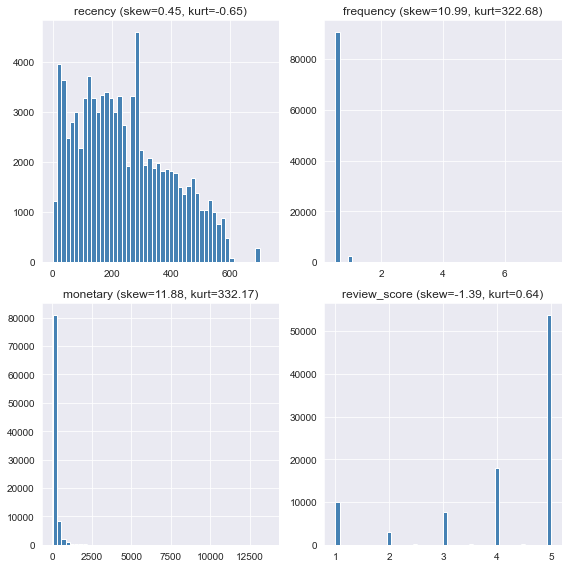

In [4]:
# Examen des variables numériques
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Examen des features numériques\n" + Style.RESET_ALL)
num_var = ['recency', 'frequency', 'monetary', 'review_score']

print(Fore.GREEN + "► Données statistiques :" + Style.RESET_ALL)
display(data[num_var].describe())

print(Fore.GREEN + "► Représentation graphique :" + Style.RESET_ALL)
fig = plt.figure(figsize=(8,8))
for i, var in enumerate(num_var):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(f"{var} (skew={data[var].skew():.2f}, kurt={data[var].kurtosis():.2f})", fontsize=12)
    ax.hist(data[var].values, bins=50, color='steelblue', density=False, edgecolor=None)
plt.tight_layout()
plt.show()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="preprc_num"></a>
### 2.4 - Transformation des features numériques

#### Feature 'recency'

In [5]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Transformation de la feature 'recency'\n" + Style.RESET_ALL)

# Transformation
df = data['recency'].copy()
fct.set_param_ssc('recency', df.mean(), df.std())
df = (df - df.mean()) / df.std()

# Données statistiques variable initiale
print(Fore.GREEN + "► Données statistiques variable initiale / transformée:" + Style.RESET_ALL)
display(pd.concat([pd.DataFrame(data['recency'].describe()).rename(columns={'recency': 'initiale'}),
                   pd.DataFrame(df.describe()).rename(columns={'recency': 'transformée'})], axis=1))

# Modification du jeu de données
data['recency'] = df

Transformation de la feature 'recency'

► Données statistiques variable initiale / transformée:


,initiale,transformée
count,93396.000,93396.000
mean,242.388,-0.000
std,153.164,1.000
min,0.000,-1.583
25%,118.488,-0.809
50%,222.823,-0.128
75%,351.475,0.712
max,728.494,3.174


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

#### Feature 'frequency'

In [6]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Transformation de la feature 'frequency'\n" + Style.RESET_ALL)

# Transformation
df = data['frequency'].apply([lambda x: x if x<=1 else 1])
fct.set_param_ssc('frequency', df['<lambda>'].mean(), df['<lambda>'].std())
df = (df - df['<lambda>'].mean()) / df['<lambda>'].std()

# Données statistiques variable initiale
print(Fore.GREEN + "► Données statistiques variable initiale / transformée:" + Style.RESET_ALL)
display(pd.concat([pd.DataFrame(data['frequency'].describe()).rename(columns={'frequency': 'initiale'}),
                   pd.DataFrame(df.describe()).rename(columns={'<lambda>': 'transformée'})], axis=1))

# Modification du jeu de données
data['frequency'] = df

Transformation de la feature 'frequency'

► Données statistiques variable initiale / transformée:


,initiale,transformée
count,93396.000,93396.000
mean,0.517,-0.000
std,0.104,1.000
min,0.500,-0.176
25%,0.500,-0.176
50%,0.500,-0.176
75%,0.500,-0.176
max,7.500,5.681


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

#### Feature 'monetary'

In [7]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Transformation de la feature 'monetary'\n" + Style.RESET_ALL)

# Transformation
df = data['monetary'].apply([lambda x: x if x<=700 else 700])
fct.set_param_ssc('monetary', df['<lambda>'].mean(), df['<lambda>'].std())
df = (df - df.mean()) / df.std()

# Données statistiques variable initiale
print(Fore.GREEN + "► Données statistiques variable initiale / transformée:" + Style.RESET_ALL)
display(pd.concat([pd.DataFrame(data['monetary'].describe()).rename(columns={'monetary': 'initiale'}),
                   pd.DataFrame(df.describe()).rename(columns={'<lambda>': 'transformée'})], axis=1))

# Modification du jeu de données
data['monetary'] = df

Transformation de la feature 'monetary'

► Données statistiques variable initiale / transformée:


,initiale,transformée
count,93396.000,93396.000
mean,174.135,0.000
std,263.117,1.000
min,10.070,-1.001
25%,64.000,-0.637
50%,110.440,-0.323
75%,189.000,0.208
max,13664.080,3.663


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

#### Feature 'review_score'

In [8]:
# review_score
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Transformation de la feature 'review_score'\n" + Style.RESET_ALL)

# Transformation
df = data['review_score'].copy()
fct.set_param_ssc('review_score', df.mean(), df.std())
df = (df - df.mean()) / df.std()

# Données statistiques variable initiale
print(Fore.GREEN + "► Données statistiques variable initiale / transformée:" + Style.RESET_ALL)
display(pd.concat([pd.DataFrame(data['recency'].describe()).rename(columns={'recency': 'initiale'}),
                   pd.DataFrame(df.describe()).rename(columns={'review_score': 'transformée'})], axis=1))

# Modification du jeu de données
data['review_score'] = df

Transformation de la feature 'review_score'

► Données statistiques variable initiale / transformée:


,initiale,transformée
count,93396.000,93396.000
mean,-0.000,0.000
std,1.000,1.000
min,-1.583,-2.344
25%,-0.809,-0.079
50%,-0.128,0.676
75%,0.712,0.676
max,3.174,0.676


In [9]:
# Paramètres de transformation des variables numériques : valeurs, sauvegarde et vérification en lecture
print(fct.ssc_tr_param)
fct.save_param_ssc()
print(fct.read_param_ssc())

{'fname': ['recency', 'frequency', 'monetary', 'review_score'], 'mean': [242.38812028602723, 0.515027410167459, 158.1736013319628, 4.104668770016322], 'std': [153.16356320775793, 0.08536954995946326, 147.93134677414037, 1.3247572317881628]}
{'fname': ['recency', 'frequency', 'monetary', 'review_score'], 'mean': [242.38812028602723, 0.515027410167459, 158.1736013319628, 4.104668770016322], 'std': [153.16356320775793, 0.08536954995946326, 147.93134677414037, 1.3247572317881628]}


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="dataset"></a>
### 2.5 - Résultat du jeu transformé
Le jeu transformé contient :
- 4 variables numériques, dont les 3 variables de base RFM ;
- 8 variables catégorielles OHE.

In [10]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Résultat du jeu transformé\n" + Style.RESET_ALL)

display(data.head())
display(data.info())

print(Fore.GREEN + "► Variables numériques:" + Style.RESET_ALL, num_var)
print(Fore.GREEN + "► Variables catégorielles:" + Style.RESET_ALL, cat_var)

Résultat du jeu transformé



,recency,frequency,monetary,review_score,state_MG,state_OS,state_RJ,state_SP,pay_seq_0,pay_seq_1,pay_inst_0,pay_inst_1
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.826,-0.176,-0.110,0.676,-0.342,-0.579,-0.358,0.896,0.031,-0.176,-0.695,0.672
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.806,-0.176,-0.885,-0.079,-0.342,-0.579,-0.358,0.896,0.031,-0.176,0.744,-0.719
0000f46a3911fa3c0805444483337064,1.953,-0.176,-0.486,-0.834,-0.342,1.149,-0.358,-0.648,0.031,-0.176,-0.695,0.672
0000f6ccb0745a6a4b88665a16c9f078,0.543,-0.176,-0.774,-0.079,-0.342,1.149,-0.358,-0.648,0.031,-0.176,-0.695,0.672
0004aac84e0df4da2b147fca70cf8255,0.328,-0.176,0.262,0.676,-0.342,-0.579,-0.358,0.896,0.031,-0.176,-0.695,0.672


<class 'pandas.core.frame.DataFrame'>
Index: 93396 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recency       93396 non-null  float64
 1   frequency     93396 non-null  float64
 2   monetary      93396 non-null  float64
 3   review_score  93396 non-null  float64
 4   state_MG      93396 non-null  float64
 5   state_OS      93396 non-null  float64
 6   state_RJ      93396 non-null  float64
 7   state_SP      93396 non-null  float64
 8   pay_seq_0     93396 non-null  float64
 9   pay_seq_1     93396 non-null  float64
 10  pay_inst_0    93396 non-null  float64
 11  pay_inst_1    93396 non-null  float64
dtypes: float64(12)
memory usage: 9.3+ MB


None

► Variables numériques: ['recency', 'frequency', 'monetary', 'review_score']
► Variables catégorielles: ['state_MG', 'state_OS', 'state_RJ', 'state_SP', 'pay_seq_0', 'pay_seq_1', 'pay_inst_0', 'pay_inst_1']


[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="acp"></a>
## 3 - Analyse en composantes principales centrée sur les variables numériques
L'ACP met en évidence les possibilités de segmentation suivantes, en fonction de :
- (a) la fréquence des commandes : 1 seule commande ou plusieurs commandes ;
- (b) la récence des commandes : seuil(s) à déterminer (inférieur à 600 jours) ;
- (c) le montant cumulé des commandes, seuil(s) à déterminer, autour de la valeur moyenne ;
- (d) la satisfaction des clients mesurée par le review_score, seuil(s) à déterminer avec un fort intérêt à considérer la valeur 4.

Avec un seuil par variable, et en évitant de sub-diviser le groupe des clients ayant effectué plusieurs commandes, cela pourrait représenter 5 clusters.

Par ailleurs, il est envisageable de croiser ces groupes avec certaines valeurs de variables catégorielles pour affiner la définition des groupes ou envisager de les sub-diviser.

L'examen montre le potentiel suivant :
- Un seul moyen de paiement utilisé par commande : applicable aux 5 groupes.
- Paiement en plusieurs fois : applicable aux 5 groupes ; ou éventuellement sub-division en fonction que le paiement s'effectue ou pas en plusieurs fois : applicable potentiellement aux groupes (a), (b), (d) et (e).
- Clients localisés dans l'Etat de Sao Paulo : applicable aux 5 groupes.

Notons que la dispersion des individus ne permet pas de dire que cela conduirait à des segments homogènes et cela constitue plutôt des pistes d'amélioration à confirmer avec des données complémentaires sur les clients.

<a id="acp_gen"></a>
### 3.1 - ACP sur l'ensemble des features numériques
L'ACP et la représentation graphique permettent les constatations suivantes :
- Le plan F1-F2 montre que la population est divisée en 2 groupes principaux séparés linéairement et qui semblent se distinguer en fonction des features 'frequency' et 'monetary'.
&nbsp;
- La visualisation dans le plan F3-F4 montre par ailleurs que le groupe du bas pourrait être sub-divisé en plusieurs groupes (2 ou 3) dans le sens de la feature "recency".
&nbsp;
- Le plan F1-F2 montre que l'axe d'orientation de la feature 'review_score' est parallèle à la ligne séparant les 2 principaux groupes d'individus, et qu'elle n'a donc pas d'influence sur leur division.
&nbsp;
- La coloration des individus en fonction du 'review_score' montre que chaque groupe peut probablement se diviser en sous-groupes selon la satisfaction des clients.

Analyse en composantes principales

► Composantes principales:
	- n_components_ :  4
	- explained_variance_ : [1.178 1.026 0.978 0.818]
	- explained_variance_ratio_ : [0.294 0.257 0.245 0.204]
	- singular_values_ : [331.671 309.567 302.289 276.341]
	- components_ : (4, 4) 

	→ Éboulis des valeurs propres


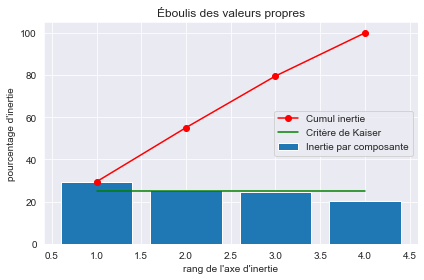

	→ Cercle(s) des corrélations et projections des individus dans les plans factoriels


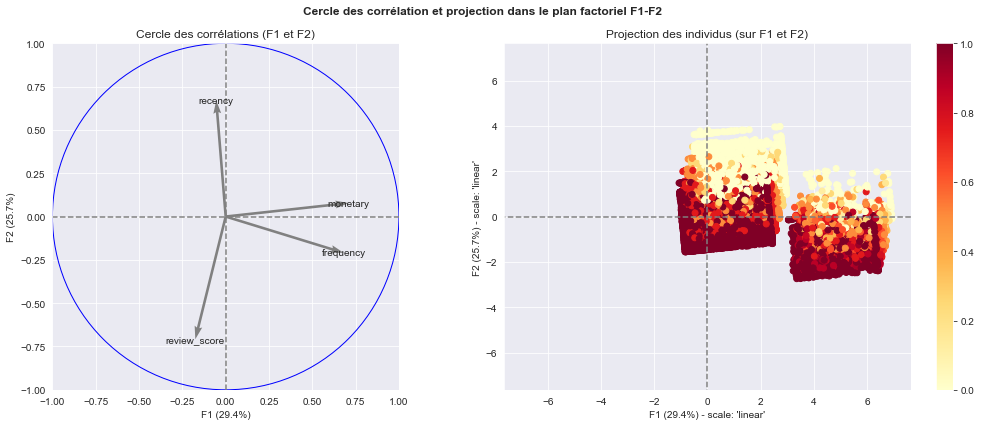

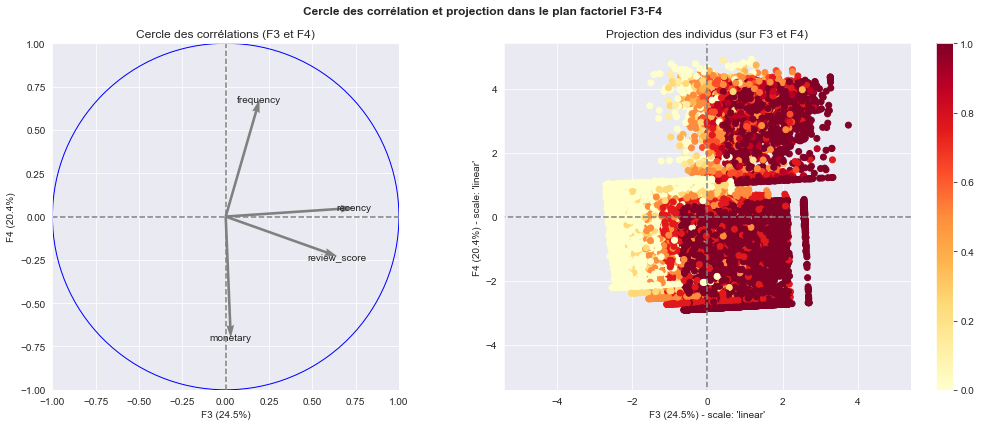

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Analyse en composantes principales\n" + Style.RESET_ALL)

# Choix du nombre de composantes à calculer
n_comp = len(num_var)

# Sélection des caractéristiques à prendre en compte dans l'ACP et préparation des données
X = data[num_var].values
pca_labels = np.array(num_var) # pour les labels de c_labels

# Calcul des composantes principales
pca = PCA(n_components=n_comp)
pca.fit(X)

print(Fore.GREEN + "► Composantes principales:" + Style.RESET_ALL)
np.set_printoptions(precision=3)
print("\t- n_components_ : ", pca.n_components_)
print("\t- explained_variance_ :", pca.explained_variance_)
print("\t- explained_variance_ratio_ :", pca.explained_variance_ratio_)
print("\t- singular_values_ :", pca.singular_values_)
print("\t- components_ :", np.shape(pca.components_), '\n')

# Éboulis des valeurs propres
print(Fore.LIGHTBLUE_EX + "\t→ Éboulis des valeurs propres" + Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
print(Fore.LIGHTBLUE_EX + "\t→ Cercle(s) des corrélations et projections des individus dans les plans factoriels" + Style.RESET_ALL)
pcs = pca.components_
X_projected = pca.transform(X)

# Liste des plans pour l'affichage graphique
plans = [[i,i+1] for i in range(1, n_comp, 2)]
if n_comp % 2 != 0:
    plans.append([1, n_comp])

# Définition des échelles de tracé (projection des individus) et tracé des graphiques
color = data['review_score'].values
color = (color - color.min()) / (color.max() - color.min())
scale = 'linear', 'linear'
c_lims = -1, 1, -1, 1
for plan in plans:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale,
                           color=color, cmap='YlOrRd',
                           p_labels = None, c_labels=pca_labels, c_label_rotation=0,
                           c_lims=c_lims, filter=None)

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="acp_rfm"></a>
### 3.2 - ACP sur les feature RFM
Dans cette section, nous visons à examiner ce que nous pouvons tirer de l'ACP sur les seules variables RFM.

Nous faisons les constatations suivantes :
- Le graphique coloré en fonction de la fréquence des commandes montre 2 groupes d'individus séparés : celui de gauche (97%) des clients n'ayant effectué qu'une commande et celui de droite pour les autres.
&nbsp;
- Les graphiques montrent une séparation selon un seuil de récence. L'analyse univariée du notebook 1 a montré que la récence sépare la population en 2 parties (récence < 600 jours et récence > ~690 jours) et que la population concernée par une récence supérieure à 600 jours est de 334 clients. Ces 334 clients figurent donc dans les 2 petits groupes au-dessus des 2 grands groupes et le petit groupe de droite ne représente que quelques unités. Cependant, étant donné le petit nombre de clients que cela concerne, ainsi que pour tenir compte du fait que l'ajout de nouvelles données ne manqueront pas de combler ce gap de récence, nous ne pouvons pas considérer de segmentation sur cette valeur de récence.
&nbsp;
- Le graphique coloré en fonction de la récence montre une progression selon son axe et donc une possible segmentation en fonction d'une ou plusieurs valeurs de cette feature.
&nbsp;
- Le graphique coloré en fonction du montant montre une progression selon son axe et donc une possible segmentation en fonction d'une ou plusieurs valeurs de cette feature.

Au total, nous visualisons une segmentation évidente en deux parties en fonction de la fréquence, et nous pouvons par ailleurs envisager des segmentations en fonction du montant ou de la récence.

Analyse en composantes principales

  - 3 variables
  - 93396 individus (clients)

► Composantes principales:
	- n_components_ :  3
	- explained_variance_ : [1.172 1.    0.827]
	- explained_variance_ratio_ : [0.391 0.333 0.276]
	- singular_values_ : [330.912 305.619 277.992]
	- components_ : (3, 3) 

	→ Éboulis des valeurs propres


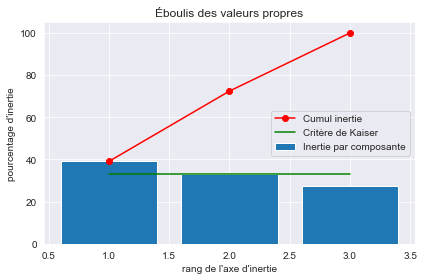

	→ Cercle(s) des corrélations et projections des individus dans les plans factoriels
Population en fonction de la fréquence des commandes



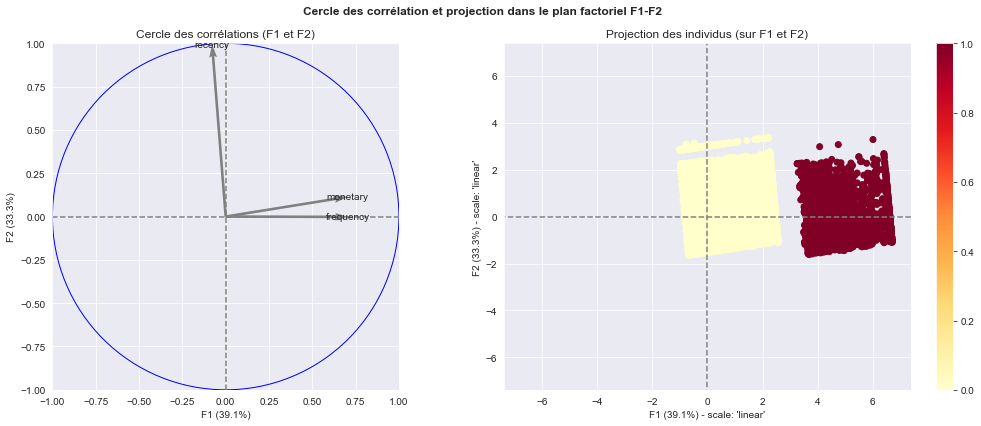

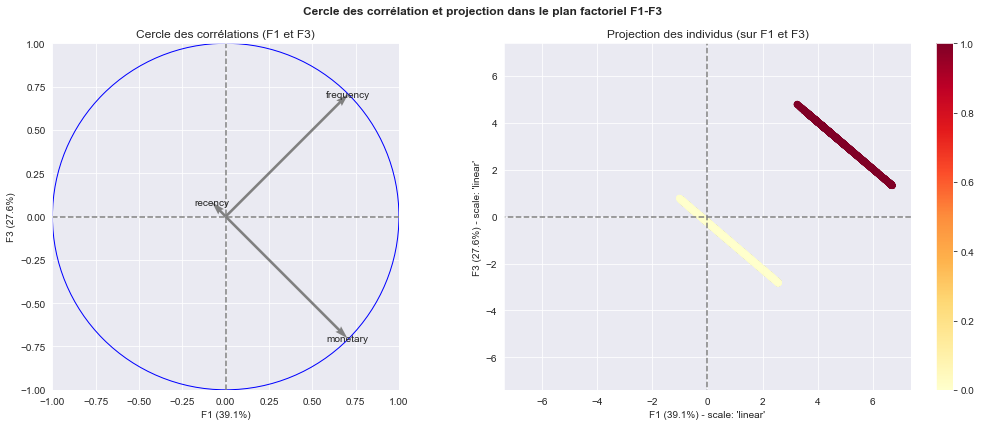

Population en fonction de la récence des commandes



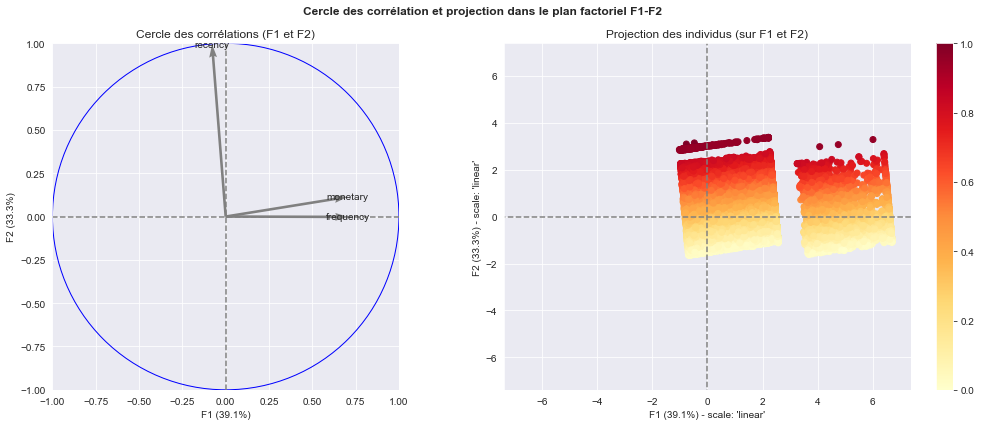

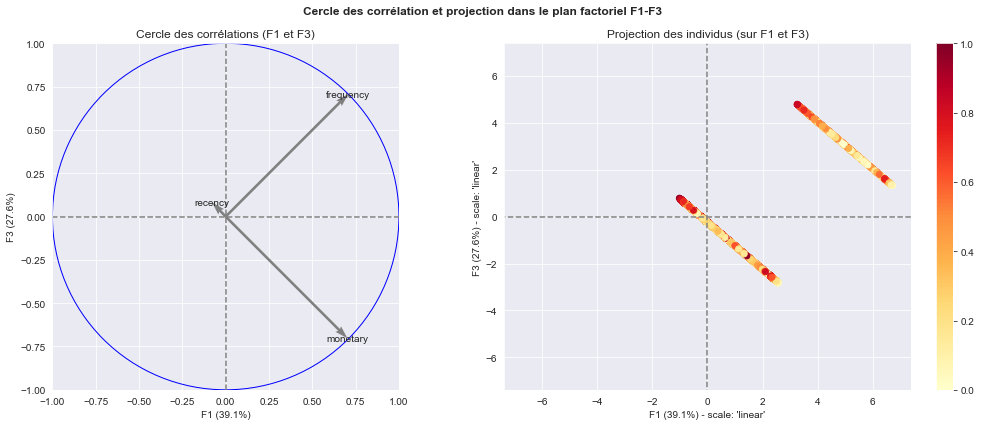

Population en fonction du montant cumulé des commandes



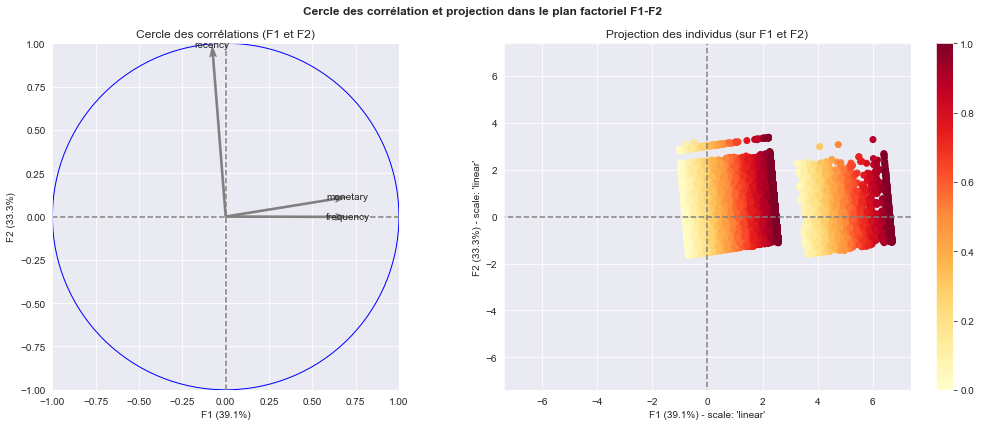

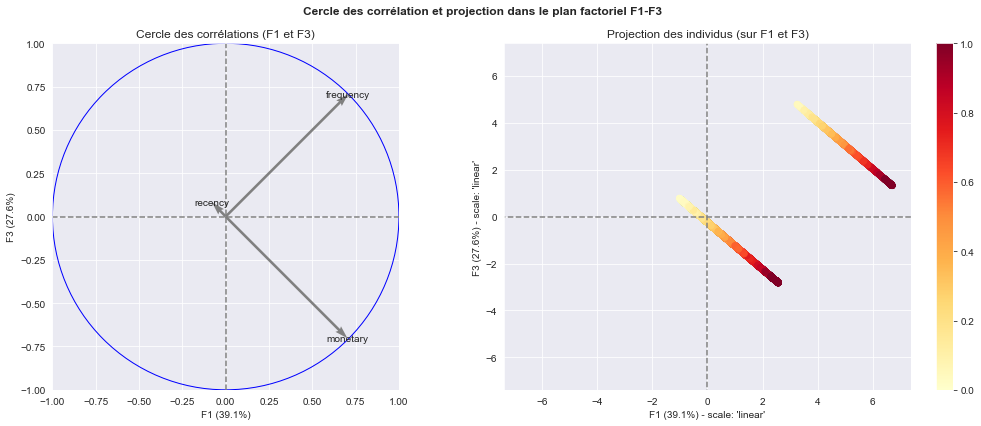

In [12]:
# Choix du nombre de composantes à calculer
n_comp = 3

# Sélection des caractéristiques à prendre en compte dans l'ACP et préparation des données
features = ['recency', 'frequency', 'monetary']
data_pca = data[features].copy()
X = data_pca.values
names = np.array(data_pca.index) # pour les labels de p_labels
pca_labels = np.array(features) # pour les labels de c_labels

print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Analyse en composantes principales\n" + Style.RESET_ALL)
print("  -", data_pca.shape[1], 'variables')
print("  -", data_pca.shape[0], 'individus (clients)\n' + fct.Style.RESET_ALL)

# Calcul des composantes principales
pca = PCA(n_components=n_comp)
pca.fit(X)

print(Fore.GREEN + "► Composantes principales:" + Style.RESET_ALL)
np.set_printoptions(precision=3)
print("\t- n_components_ : ", pca.n_components_)
print("\t- explained_variance_ :", pca.explained_variance_)
print("\t- explained_variance_ratio_ :", pca.explained_variance_ratio_)
print("\t- singular_values_ :", pca.singular_values_)
print("\t- components_ :", np.shape(pca.components_), '\n')

# Éboulis des valeurs propres
print(Fore.LIGHTBLUE_EX + "\t→ Éboulis des valeurs propres" + Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
print(Fore.LIGHTBLUE_EX
      + "\t→ Cercle(s) des corrélations et projections des individus dans les plans factoriels"
      + Style.RESET_ALL)
pcs = pca.components_
X_projected = pca.transform(X)

# Liste des plans pour l'affichage graphique
plans = [[i,i+1] for i in range(1, n_comp, 2)]
if n_comp % 2 != 0:
    plans.append([1, n_comp])

# Examen de la population en fonction de la fréquence d'achat
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Population en fonction de la fréquence des commandes\n" + Style.RESET_ALL)
color = data_pca['frequency'].values
color = (color - color.min()) / (color.max() - color.min())
scale = 'linear', 'linear'
c_lims = -1, 1, -1, 1
for plan in plans:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale,
                           color=color, cmap='YlOrRd',
                           p_labels = None, c_labels=pca_labels, c_label_rotation=0,
                           c_lims=c_lims, filter=None)

# Examen de la population en fonction de la récence des commandes
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Population en fonction de la récence des commandes\n" + Style.RESET_ALL)
color = data_pca['recency'].values
color = (color - color.min()) / (color.max() - color.min())
scale = 'linear', 'linear'
c_lims = -1, 1, -1, 1
for plan in plans:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale,
                           color=color, cmap='YlOrRd',
                           p_labels = None, c_labels=pca_labels, c_label_rotation=0,
                           c_lims=c_lims, filter=None)

# Examen de la population en fonction du montant cumulé des commandes
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Population en fonction du montant cumulé des commandes\n" + Style.RESET_ALL)
color = data_pca['monetary'].values
color = (color - color.min()) / (color.max() - color.min())
scale = 'linear', 'linear'
c_lims = -1, 1, -1, 1
for plan in plans:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale,
                           color=color, cmap='YlOrRd',
                           p_labels = None, c_labels=pca_labels, c_label_rotation=0,
                           c_lims=c_lims, filter=None)

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="acp_rfm_cat"></a>
### 3.3 - Combinaison RFM avec les variables catégorielles
La combinaison RFM avec les variables catégorielles (couleur selon leur valeur) divise naturellement les groupes en sous-groupes et appelle les remarques suivantes :
- Les clients des Etats SP, RJ et MG pourraient représenter des sous-groupes du groupe des clients n'ayant effectué qu'une seule commande.
&nbsp;
- Les clients ayant payé avec plusieurs moyens de paiement sont éparpillés et ne peuvent représenter un sous-groupe, faisant que la feature 'pay_inst_1', et plus largement 'payment_sequential' ne présente pas d'intérêt pour la segmentation.
&nbsp;
- Les clients ayant payé en plusieurs ou une seule fois semblent également éparpillés, mais dans une moindre mesure, questionnant l'intérêt de la feature 'payment_installments' pour la segmentation.

Combinaison RFM avec variables catégorielles



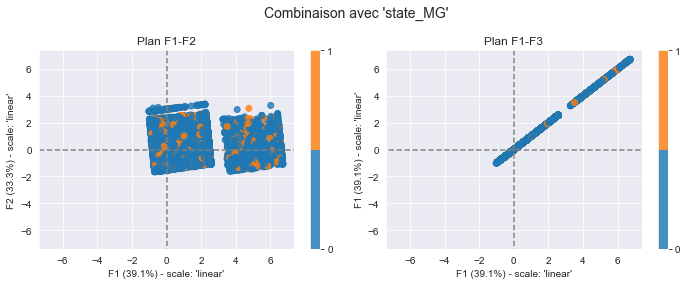

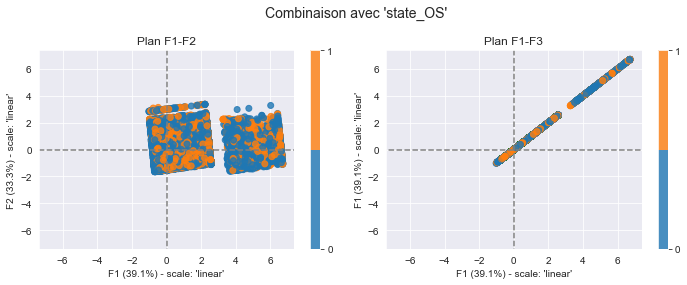

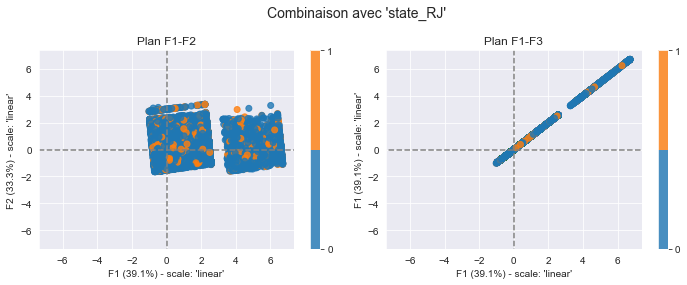

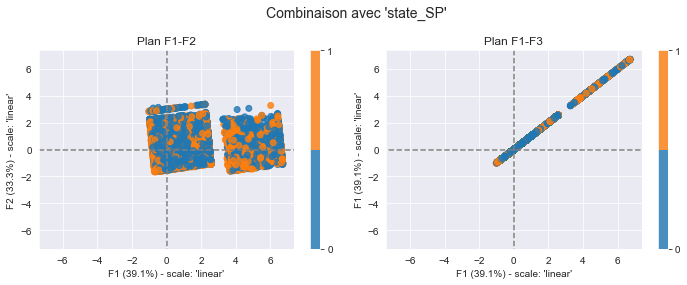

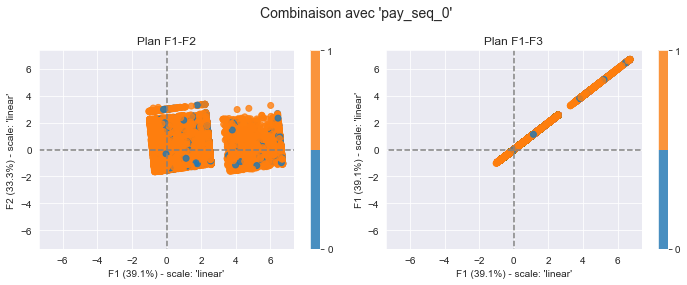

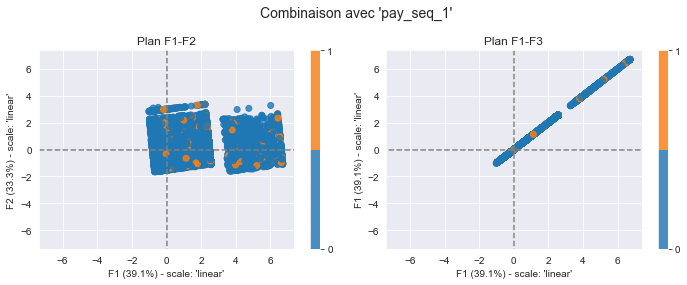

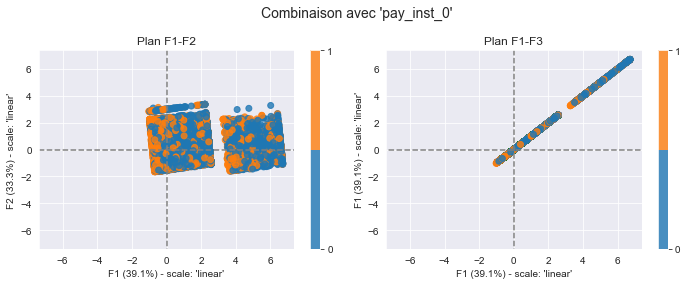

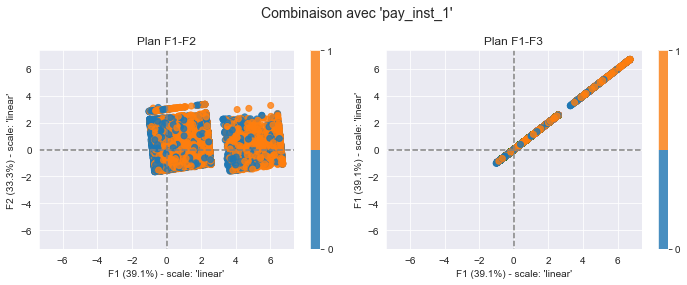

In [13]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Combinaison RFM avec variables catégorielles\n" + Style.RESET_ALL)

cmap = fct.discrete_colormap(fct.discrete_palette[:2])[0]

for var in cat_var:
    color = data[var].values
    color = (color - color.min()) / (color.max() - color.min())
    fig = plt.figure(figsize=(10, 4))

    ax1 = fig.add_subplot(121)
    dfp1 = fct.display_factorial_plan(ax1, X_projected, n_comp, pca, [1, 2], alpha=0.8, color=color, cmap=cmap)
    ax1.set_title("Plan F1-F2")
    fig.colorbar(dfp1, ax=ax1).set_ticks([0,1])

    ax2 = fig.add_subplot(122)
    dfp2 = fct.display_factorial_plan(ax2, X_projected, n_comp, pca, [1, 1], alpha=0.8, color=color, cmap=cmap)
    ax2.set_title("Plan F1-F3")
    fig.colorbar(dfp2, ax=ax2).set_ticks([0,1])

    plt.suptitle(f"Combinaison avec '{var}'", fontsize=14)
    plt.tight_layout()
    plt.show()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="acp_mix"></a>
## 4 - Analyse en composantes principales mixte variables numériques et catégorielles
Faisant suite à l'analyse précédente, nous allons examiner l'ACP mixte globale du jeu de données.

Analyse en composantes principales mixte

► Composantes principales:
	- n_components_ :  9
	- explained_variance_ : [1.376 1.104 1.056 1.025 1.001 0.961 0.915 0.907 0.654]
	- explained_variance_ratio_ : [0.153 0.123 0.117 0.114 0.111 0.107 0.102 0.101 0.073]
	- singular_values_ : [358.496 321.059 314.057 309.449 305.774 299.658 292.331 291.099 247.15 ]
	- components_ : (9, 12) 

	→ Éboulis des valeurs propres


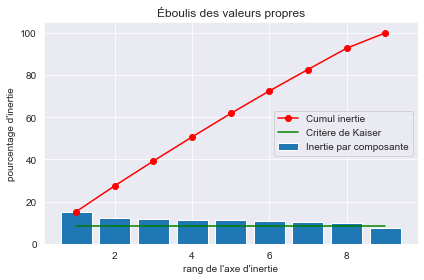

In [14]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Analyse en composantes principales mixte\n" + Style.RESET_ALL)

# Sélection des features et labels
X = data.values
pca_labels = np.array(data.columns) # pour les labels de c_labels

# Calcul des composantes principales
n_comp = data.shape[1] - 3 # nombre total de feature -3 car 3 features sont OHE donc liées
pca = PCA(n_components=n_comp)
pca.fit(X)

print(Fore.GREEN + "► Composantes principales:" + Style.RESET_ALL)
np.set_printoptions(precision=3)
print("\t- n_components_ : ", pca.n_components_)
print("\t- explained_variance_ :", pca.explained_variance_)
print("\t- explained_variance_ratio_ :", pca.explained_variance_ratio_)
print("\t- singular_values_ :", pca.singular_values_)
print("\t- components_ :", np.shape(pca.components_), '\n')

# Éboulis des valeurs propres
print(Fore.LIGHTBLUE_EX + "\t→ Éboulis des valeurs propres" + Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
pcs = pca.components_
X_projected = pca.transform(X)

# Liste des plans pour l'affichage graphique
plans = [[i,i+1] for i in range(1, n_comp, 2)]
if n_comp % 2 != 0:
    plans.append([1, n_comp])

# Échelles et limites du tracé
scale = 'linear', 'linear'
c_lims = -1, 1, -1, 1

<a id="acp_mix_states"></a>
### 4.1 - ACP mixte en mettant en évidence les Etats
L'ACP confirme la possibilité d'envisager de segmenter en fonction des 3 Etats SP, RJ et MG.

ACP mixte en mettant en évidence les Etats

	→ Cercle(s) des corrélations et projections des individus dans les plans factoriels


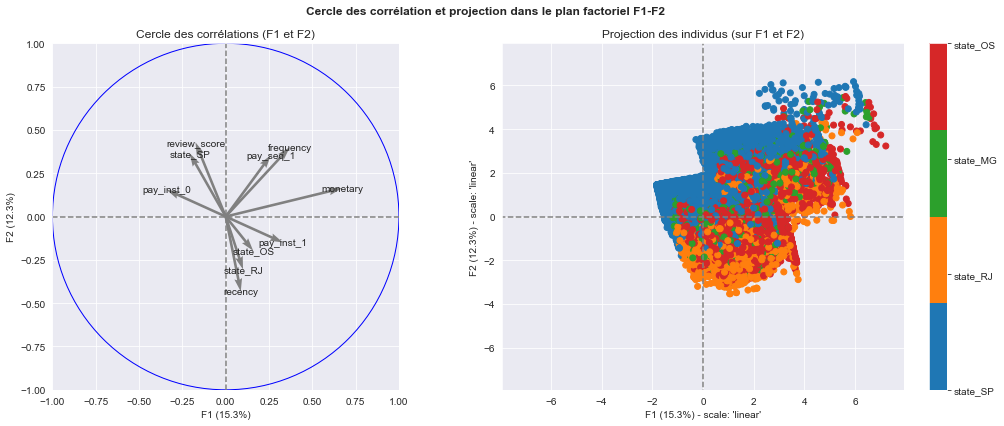

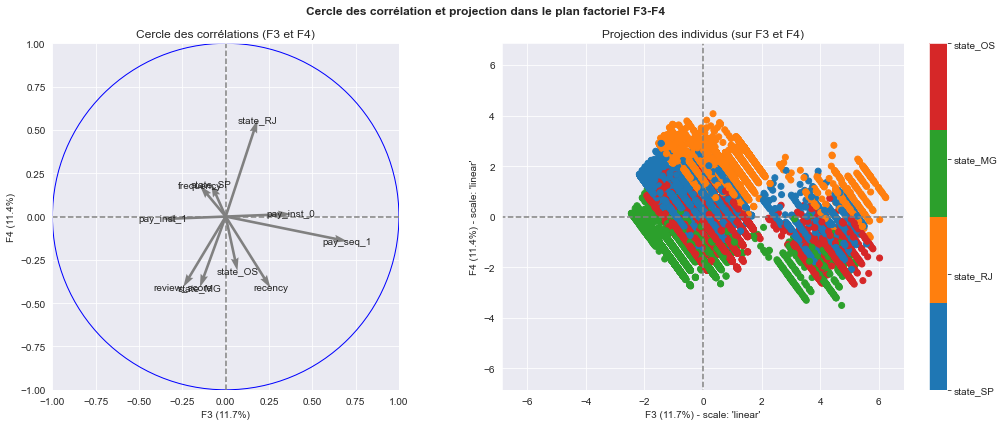

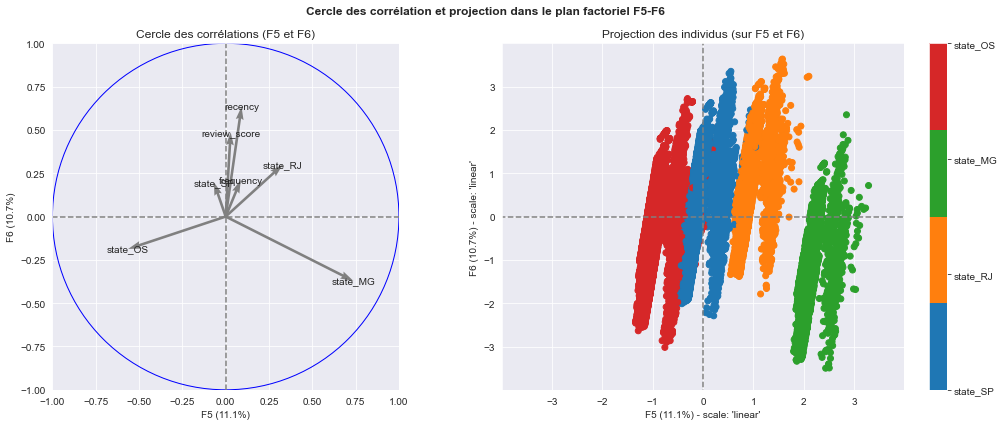

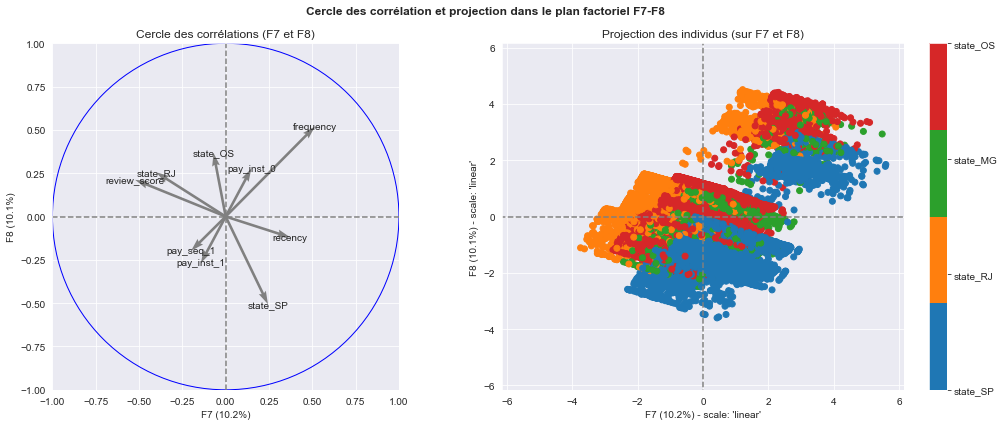

In [15]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + "ACP mixte en mettant en évidence les Etats\n"
      + Style.RESET_ALL)

# Affectation d'une couleur par Etat
states = ['state_SP', 'state_RJ', 'state_MG', 'state_OS']
df = data[states].copy()
for i, state in enumerate(states):
    df[state] = df[state].apply(lambda x: i+1 if x==df[state].max() else 0)
color = df.sum(axis=1).values
color = (color - color.min()) / (color.max() - color.min())
cnames = states
cmap = fct.discrete_colormap(fct.discrete_palette[:len(cnames)])[0]

# Tracé des plans factoriels
print(Fore.LIGHTBLUE_EX + "\t→ Cercle(s) des corrélations et projections des individus dans les plans factoriels" + Style.RESET_ALL)
for plan in plans[:4]:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale,
                           color=color, cnames=cnames, cmap=cmap,
                           p_labels = None, c_labels=pca_labels, c_label_rotation=0,
                           c_lims=c_lims, filter=0.2)

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="acp_mix_pay"></a>
### 4.2 - ACP mixte en mettant en évidence les caractéristiques de paiement
Cette ACP limitée à la feature de paiement en plusieurs fois illustre plus avant le questionnement déjà évoqué concernant cette variable sans pouvoir y répondre de manière tranchée.

ACP mixte en mettant en évidence les caractéristiques de paiement

	→ Cercle(s) des corrélations et projections des individus dans les plans factoriels


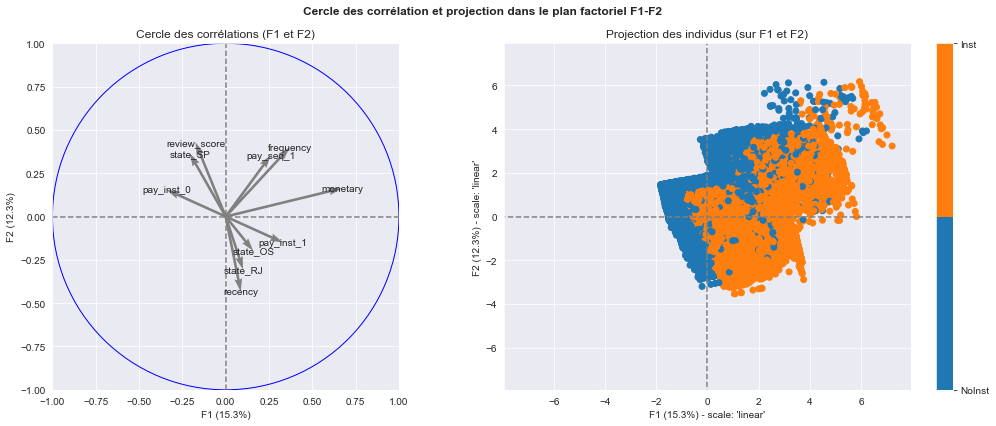

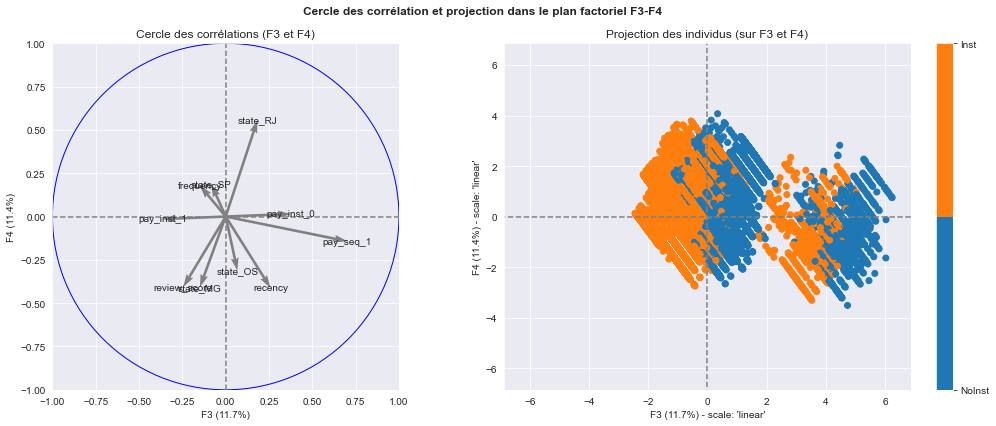

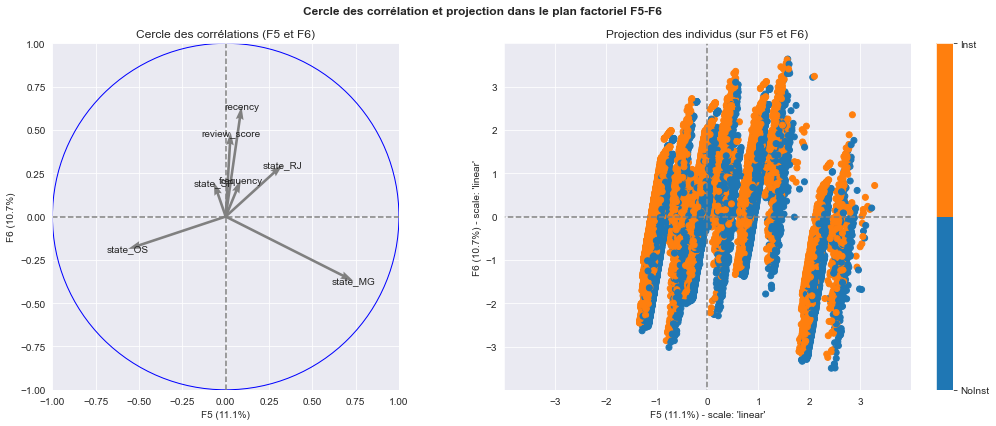

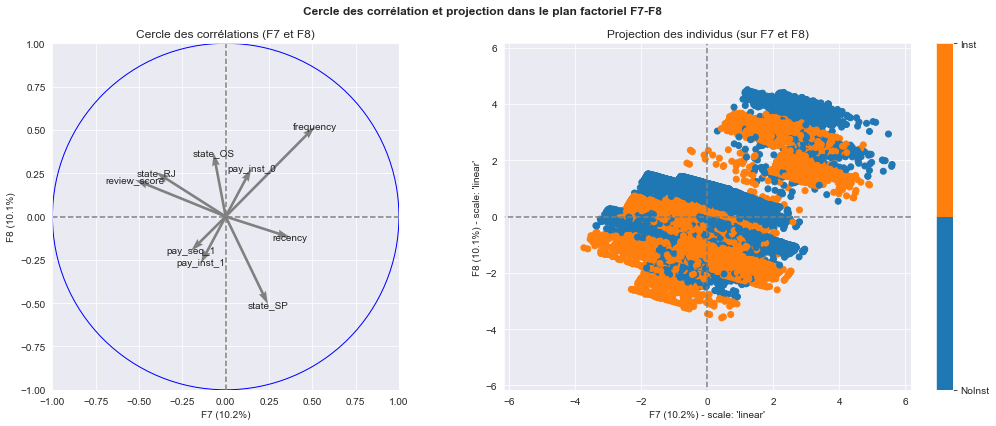

In [16]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE
      + "ACP mixte en mettant en évidence les caractéristiques de paiement\n"
      + Style.RESET_ALL)

# Affectation d'une couleur par Etat
color = data['pay_inst_1'].values
color = (color - color.min()) / (color.max() - color.min())
cnames = ['NoInst', 'Inst']
cmap = fct.discrete_colormap(fct.discrete_palette[:len(cnames)])[0]

# Tracé des plans factoriels
print(Fore.LIGHTBLUE_EX + "\t→ Cercle(s) des corrélations et projections des individus dans les plans factoriels" + Style.RESET_ALL)
for plan in plans[:4]:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale,
                           color=color, cnames=cnames, cmap=cmap,
                           p_labels = None, c_labels=pca_labels, c_label_rotation=0,
                           c_lims=c_lims, filter=0.2)

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="tsne"></a>
## 5 - Visualisation avec t-SNE

In [17]:
print(Fore.BLACK + Style.BRIGHT + Back.WHITE + "Visualisation avec t-SNE\n" + Style.RESET_ALL)
from sklearn.manifold import TSNE
features = ['recency', 'frequency', 'monetary', 'review_score']
X = data[features].values
n_components = 2

start_time = timeit.default_timer()
X_embedded = TSNE(n_components=n_components, perplexity=300.0,
                  learning_rate='auto', init='random').fit_transform(X)
elapsed = timeit.default_timer() - start_time

print(Fore.GREEN
      + f"► Temps de calcul de la réduction à {n_components} composantes :"
      + Style.RESET_ALL, f"{fct.elapsed_format(elapsed)}", '\n')

Visualisation avec t-SNE

► Temps de calcul de la réduction à {n_components} composantes : 09:07 



► Représentation graphique :


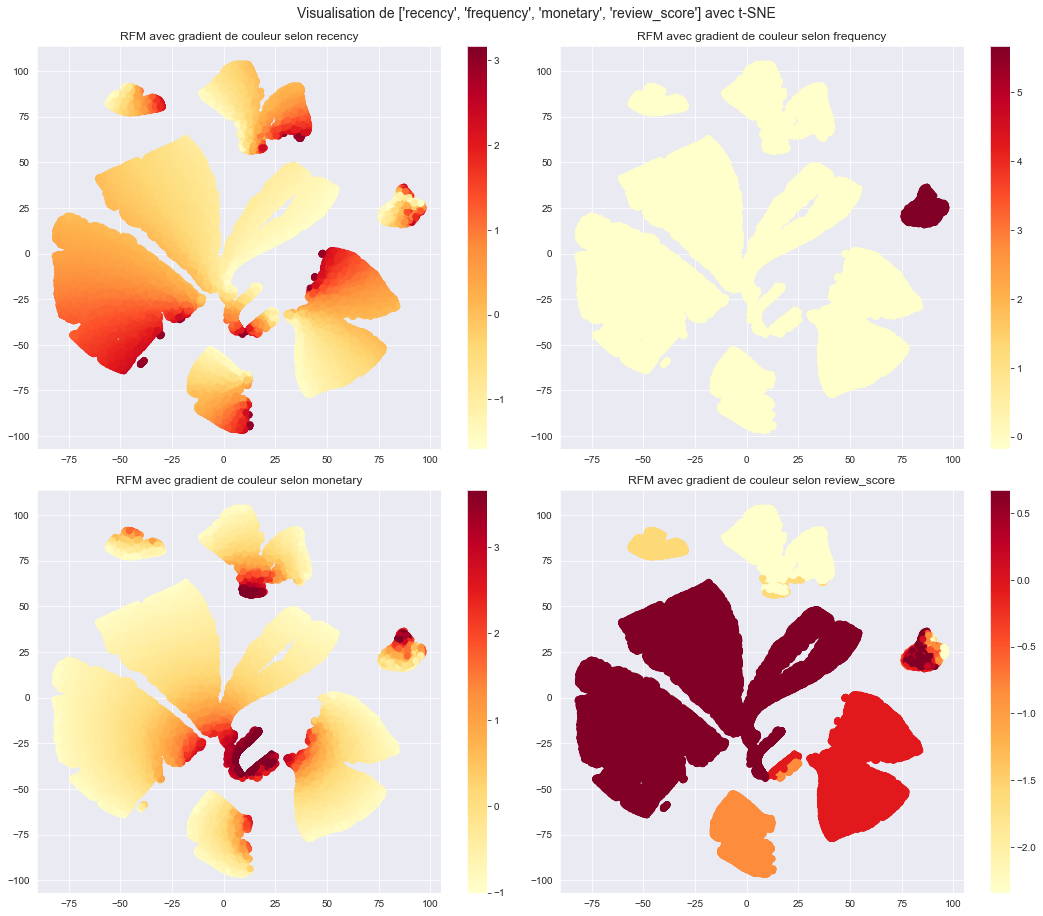

In [18]:
print(Fore.GREEN + "► Représentation graphique :" + Style.RESET_ALL)

n_rows = len(features)//2 + 1
fig= plt.figure(figsize=(15, 6*n_rows+1))
fig.suptitle(f"Visualisation de {features} avec t-SNE\n ", fontsize=14)
for i, feature in enumerate(features):
    ax = fig.add_subplot(n_rows, 2, i+1)
    sc = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=data[feature], cmap='YlOrRd',)
    ax.set_title(f"RFM avec gradient de couleur selon {feature}")
    fig.colorbar(sc, ax=ax)

plt.tight_layout()
plt.show()

[<font color='red'><em>retour sommaire</em></font>](#sommaire)

<a id="conclusion"></a>
## 6 - Conclusion
En conclusion de ce notebook, nous avons transformé les données pour les préparer aux analyses de machine learning et mené une ACP permettant d'identifier les critères les plus pertinents pour la segmentation des clients : le RFM et la satisfaction client.
En outre, l'ACP et le t-SNE nous donnent des moyens de visualisation des données en 2 dimensions, ce qui nous sera utile pour visualiser le résultat du clustering.

In [19]:
# Filtrage de la variable 'payment_sequential'
data.drop(labels=['pay_seq_0', 'pay_seq_1'], axis=1, inplace=True)

# Affichage des informations sur le jeu résultant
print(Fore.GREEN + "► Informations :" + Style.RESET_ALL)
display(data.info())
print(Fore.GREEN + "► Entête et fin de jeu de données :" + Style.RESET_ALL)
display(pd.concat([data.head(2), data.tail(2)], axis=0))

# Enregistrement au format csv du jeu de données clients transformé
data.to_csv(data_dir + "\\" + "data_ml.csv", encoding='utf-8-sig', index=True, sep=';')

# Enregistrement du dictionnaire de transformation des variables numériques
fct.save_param_ssc()

► Informations :
<class 'pandas.core.frame.DataFrame'>
Index: 93396 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recency       93396 non-null  float64
 1   frequency     93396 non-null  float64
 2   monetary      93396 non-null  float64
 3   review_score  93396 non-null  float64
 4   state_MG      93396 non-null  float64
 5   state_OS      93396 non-null  float64
 6   state_RJ      93396 non-null  float64
 7   state_SP      93396 non-null  float64
 8   pay_inst_0    93396 non-null  float64
 9   pay_inst_1    93396 non-null  float64
dtypes: float64(10)
memory usage: 7.8+ MB


None

► Entête et fin de jeu de données :


,recency,frequency,monetary,review_score,state_MG,state_OS,state_RJ,state_SP,pay_inst_0,pay_inst_1
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.826,-0.176,-0.110,0.676,-0.342,-0.579,-0.358,0.896,-0.695,0.672
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.806,-0.176,-0.885,-0.079,-0.342,-0.579,-0.358,0.896,0.744,-0.719
ffff5962728ec6157033ef9805bacc48,-0.775,-0.176,-0.166,0.676,-0.342,1.149,-0.358,-0.648,-0.695,0.672
ffffd2657e2aad2907e67c3e9daecbeb,1.607,-0.176,-0.585,0.676,-0.342,1.149,-0.358,-0.648,-0.695,0.672


[<font color='red'><em>retour sommaire</em></font>](#sommaire)